# CV : 작물 병해진단 AI 경진대회

### 코드 설명

- meta_data.py: 기본 정보가 적혀 있음. 마스크 처리를 위한 것이 가장 핵심.
- data_preprocessing.py: 데이터 전처리를 위함. Train과 Test 방식을 분리하였음. K-fold 방식을 구현하긴 하였으나 사용하지 않기에 주석처리함. 필요시 사용 가능.
- loss.py: Focal Loss 구현.
- model.py: 실제 사용한 모델.
- train_cat.py: catboost를 훈련하기 위한 코드. grid search를 약간만 변형하면 진행할 수 있으며, 그 결과들과 feature importance 확인을 위한 부분은 주석처리되어 있음.
- train_torch.py: Deep Neural Network 모델을 훈련하기 위한 코드. Batch size의 default는 44로 약 48GB의 GPU 메모리가 필요. 다만, 훈련 속도 감소를 감수한다면 amp 적용부분을 제거하면 되고, 20%가 넘는 batch 사이즈 증가가 가능.
- predict.py: 실제 추론을 위한 코드. 위의 코드를 실행할때, default값은 전혀 손대지 않았다면 별 문제 없이 진행. 체크포인트 저장 위치 등을 바꾸었다면 그 경로를 입력해줘야 함.

### 전처리

- 훈련 데이터: image, json, csv 파일, 테스트 데이터: json이 없음.
- json에는 crop, disease, risk 라벨이 주어짐. 사진이 찍힌 부위, 생육 단계, 실제 대상이 되는 존재의 bbox 등의 정보가 존재.
- 훈련 셋과 검증 셋에 데이터가 고르게 분포되도록 crop, disease, risk, 사진이 찍힌 부위, 생육 단계의 5가지 정보를 기반으로 stratified sampling을 진행. 이때, 오직 2개만 존재하는 데이터가 있어 k-fold 검증은 잠정 중단. 단일한 train-validation split만 진행.
- csv 파일에는 평균적으로 이틀에 걸친 온도, 이슬점 등의 데이터가 10분 단위로 기록되어 있음. 단, 중복 기록되거나, 일부 데이터가 누락되는 경우, 애초에 거의 대부분의 샘플에 해당 열의 데이터가 없는 경우 등을 발견.
- 대부분의 데이터에 해당 열의 데이터가 없는 경우 아예 제거. 누적일사와 CO2의 경우 존재 여부를 추가하고, 없는 경우 이와 관련된 데이터를 전부 -1로 처리(boosting 알고리즘을 사용할 예정이기에 가능한 방식)
- 논리적으로 생각했을 때, 질병의 발생 여부는 환경의 극단적인 상황에 단시간 노출되기 보다는, 일정한 한계점을 벗어난 환경에 일정 시간 이상 노출되었을 때 발생할 것으로 예측. 이에 따라 각 열의 값들에서 percentile을 구함. 총 50등분하여 전처리 수행. 이는 48시간 동안의 낮은 값부터 높은 값까지 순차적으로 나열하는 효과를 지니며, 각 값은 몇시간 동안 그 값보다 높은 수치(혹은 낮은 수치)에 작물이 노출되었는지를 대표하는 값으로 볼 수 있음. 실제, percentile 개부를 줄이면 성능이 감소됨을 확인.
- 또한, percentile 사용의 이점은 데이터 누락이나 동일 데이터의 중복 등에 매우 강건하다는 점이 특징. 이번 데이터는 확인한 바로는 이틀간의 데이터를 항상 주었지만, 전처리 방법의 특성상, 예측시 3일 혹은 일주일간의 데이터(너무 과도하게 긴 날짜가 아니라면)가 들어왔더라도 전처리에 문제 없을 뿐만 아니라 성능 측면에서도 준수한 결과를 낼것이라 추측할 수 있음.
- Image augmentation의 경우 flip과 rotation 적용. 시간에 따른 밝기 변화도 고려하기 위해 brightness에도 변화를 줌.
- 특히, 대상 작물에 대한 bbox가 주어졌기에, 이것의 사용을 극대화 하기 위해 bbox를 항상 포함하는 random crop을 진행. 이는 대상의 크기와 위치가 다양하더라도 일반화할 가능성을 높일 것으로 예상.
- 훈련 셋과 달리 테스트 셋에서는 애초에 crop, disease에 대한 정보가 빠져있음. 이에 대한 정보는 모델이 crop, disease를 예측함에 따라 데이터셋에 추가되도록 함.

In [1]:
from IPython.display import Image

In [2]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#데이터 로드 경로 지정
import os
path = '/content/drive/MyDrive/Colab Notebooks/' # 폴더 경로
os.chdir(path) # 해당 폴더로 이동

### 모델 전체 흐름도

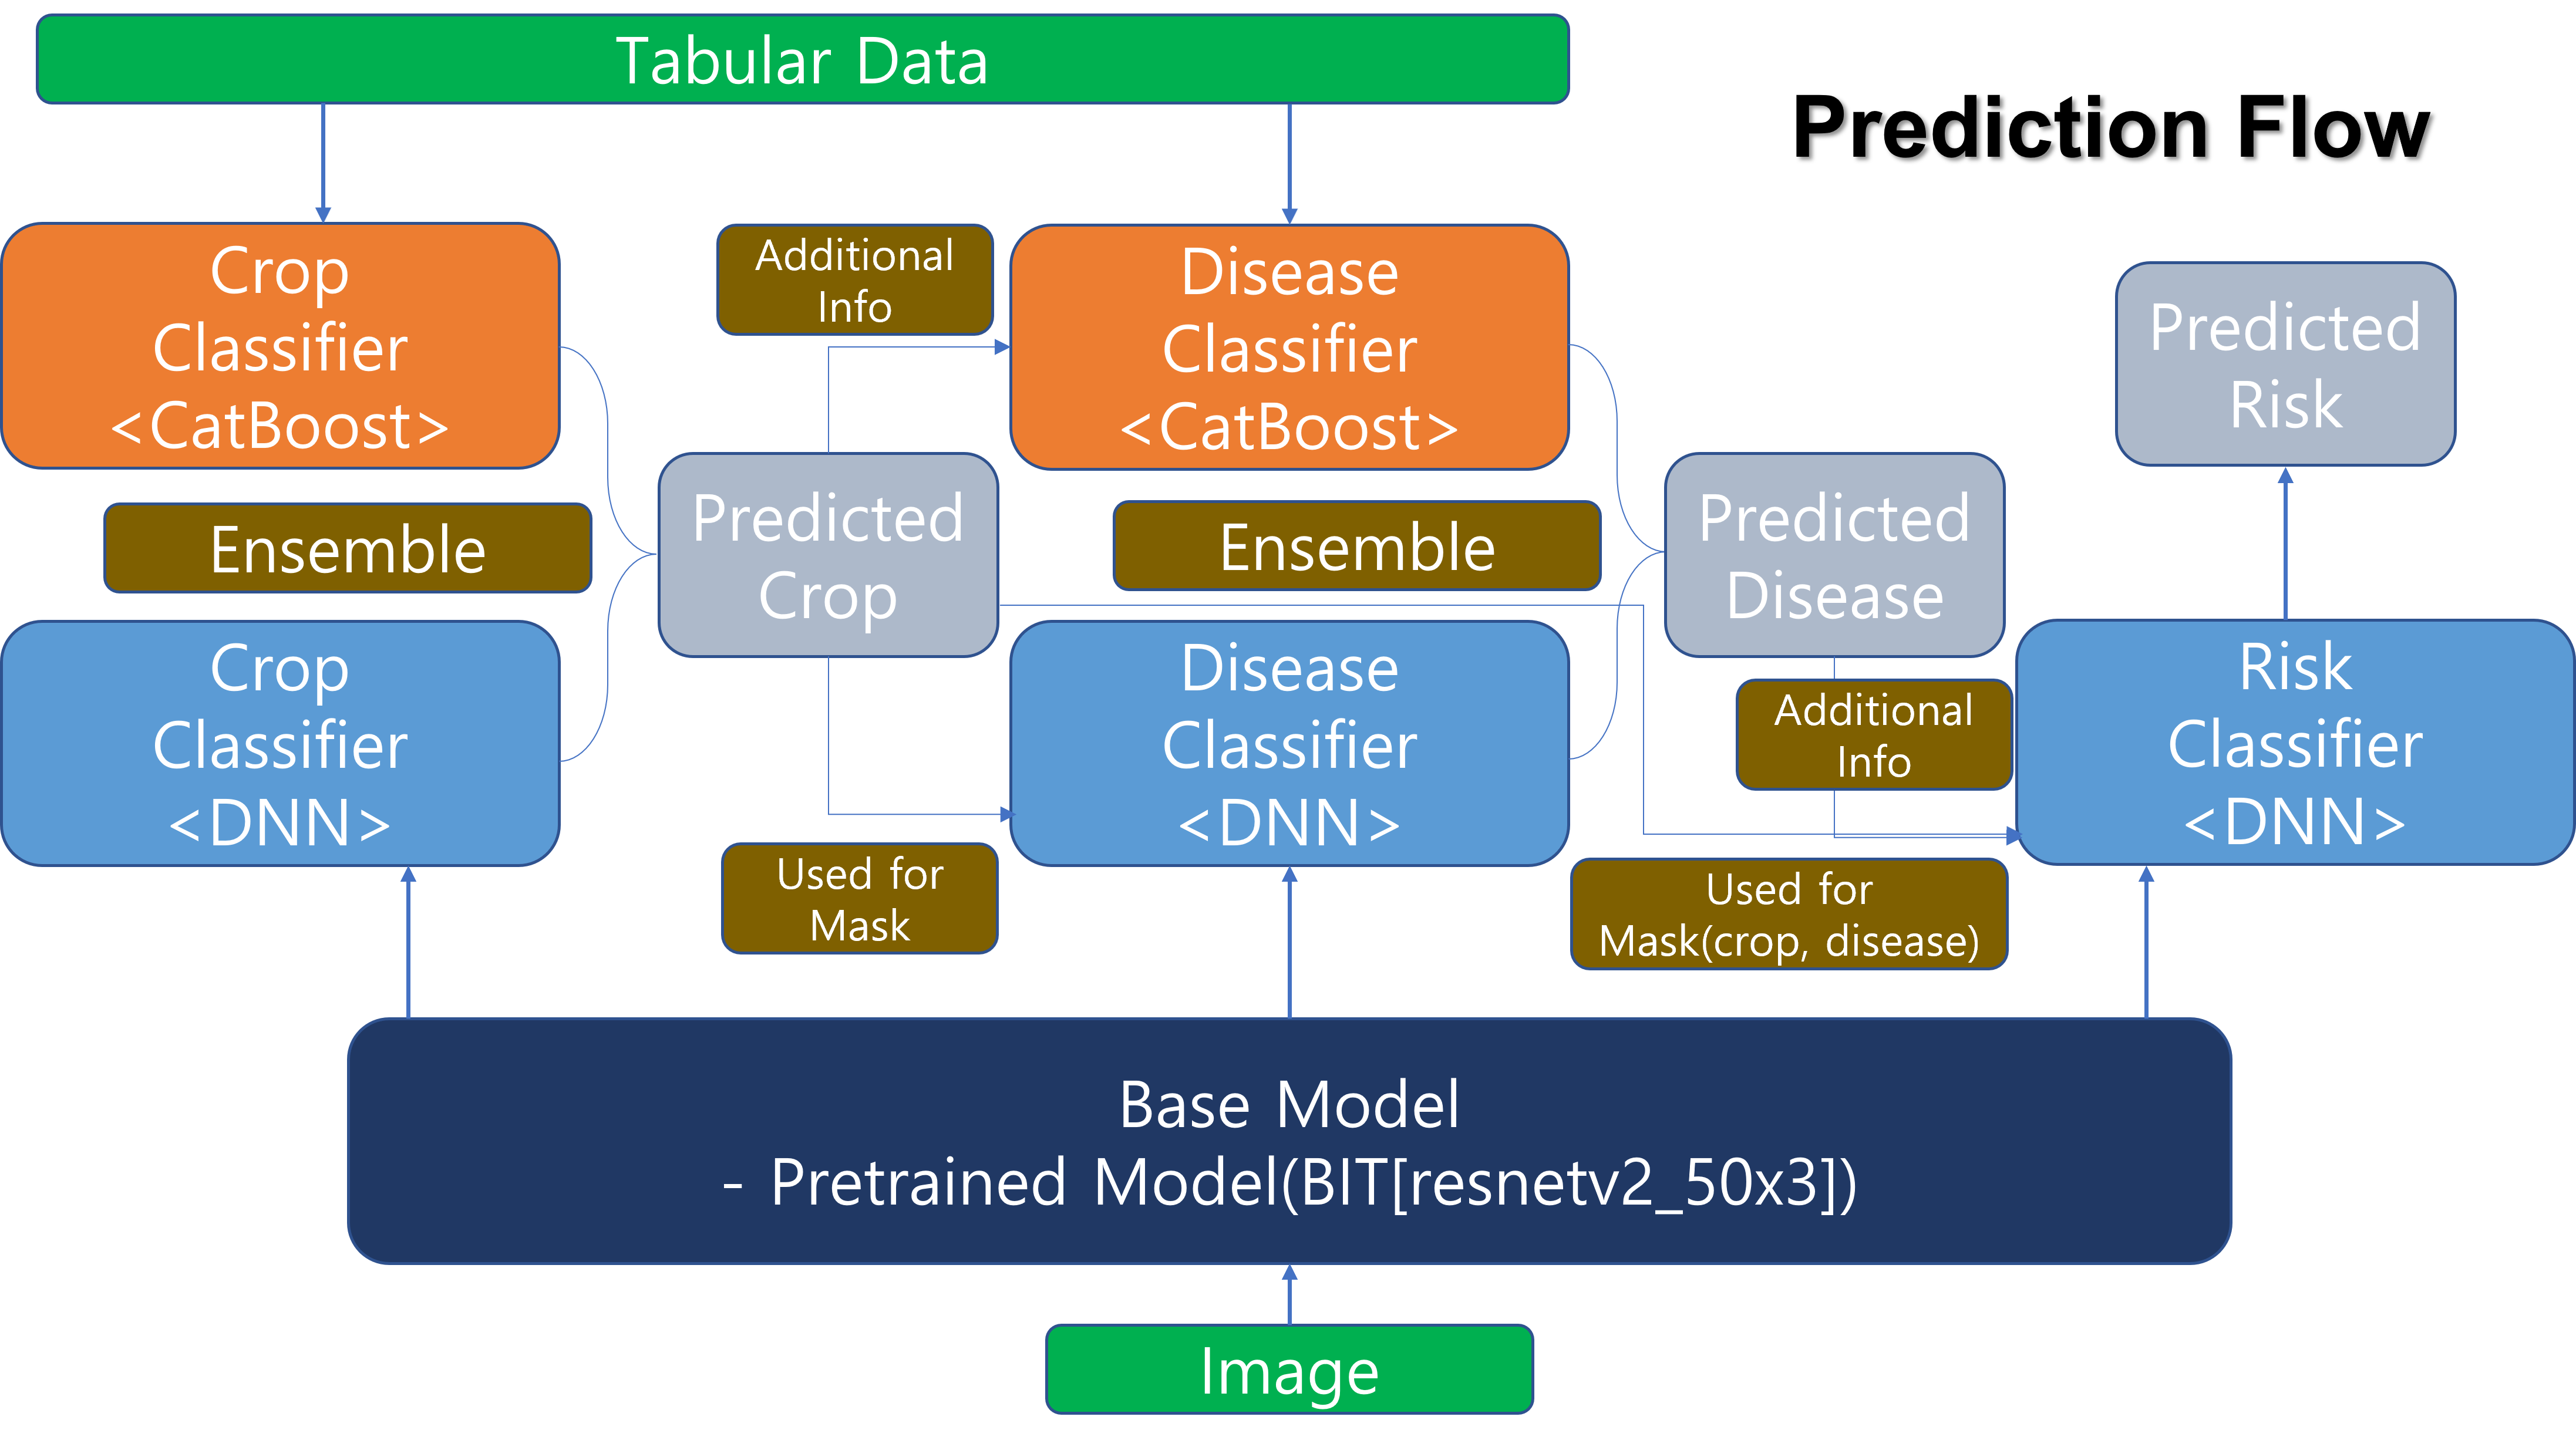

In [5]:
Image("prediction_flow.png")

### 각각의 Deep Neural Network 구조

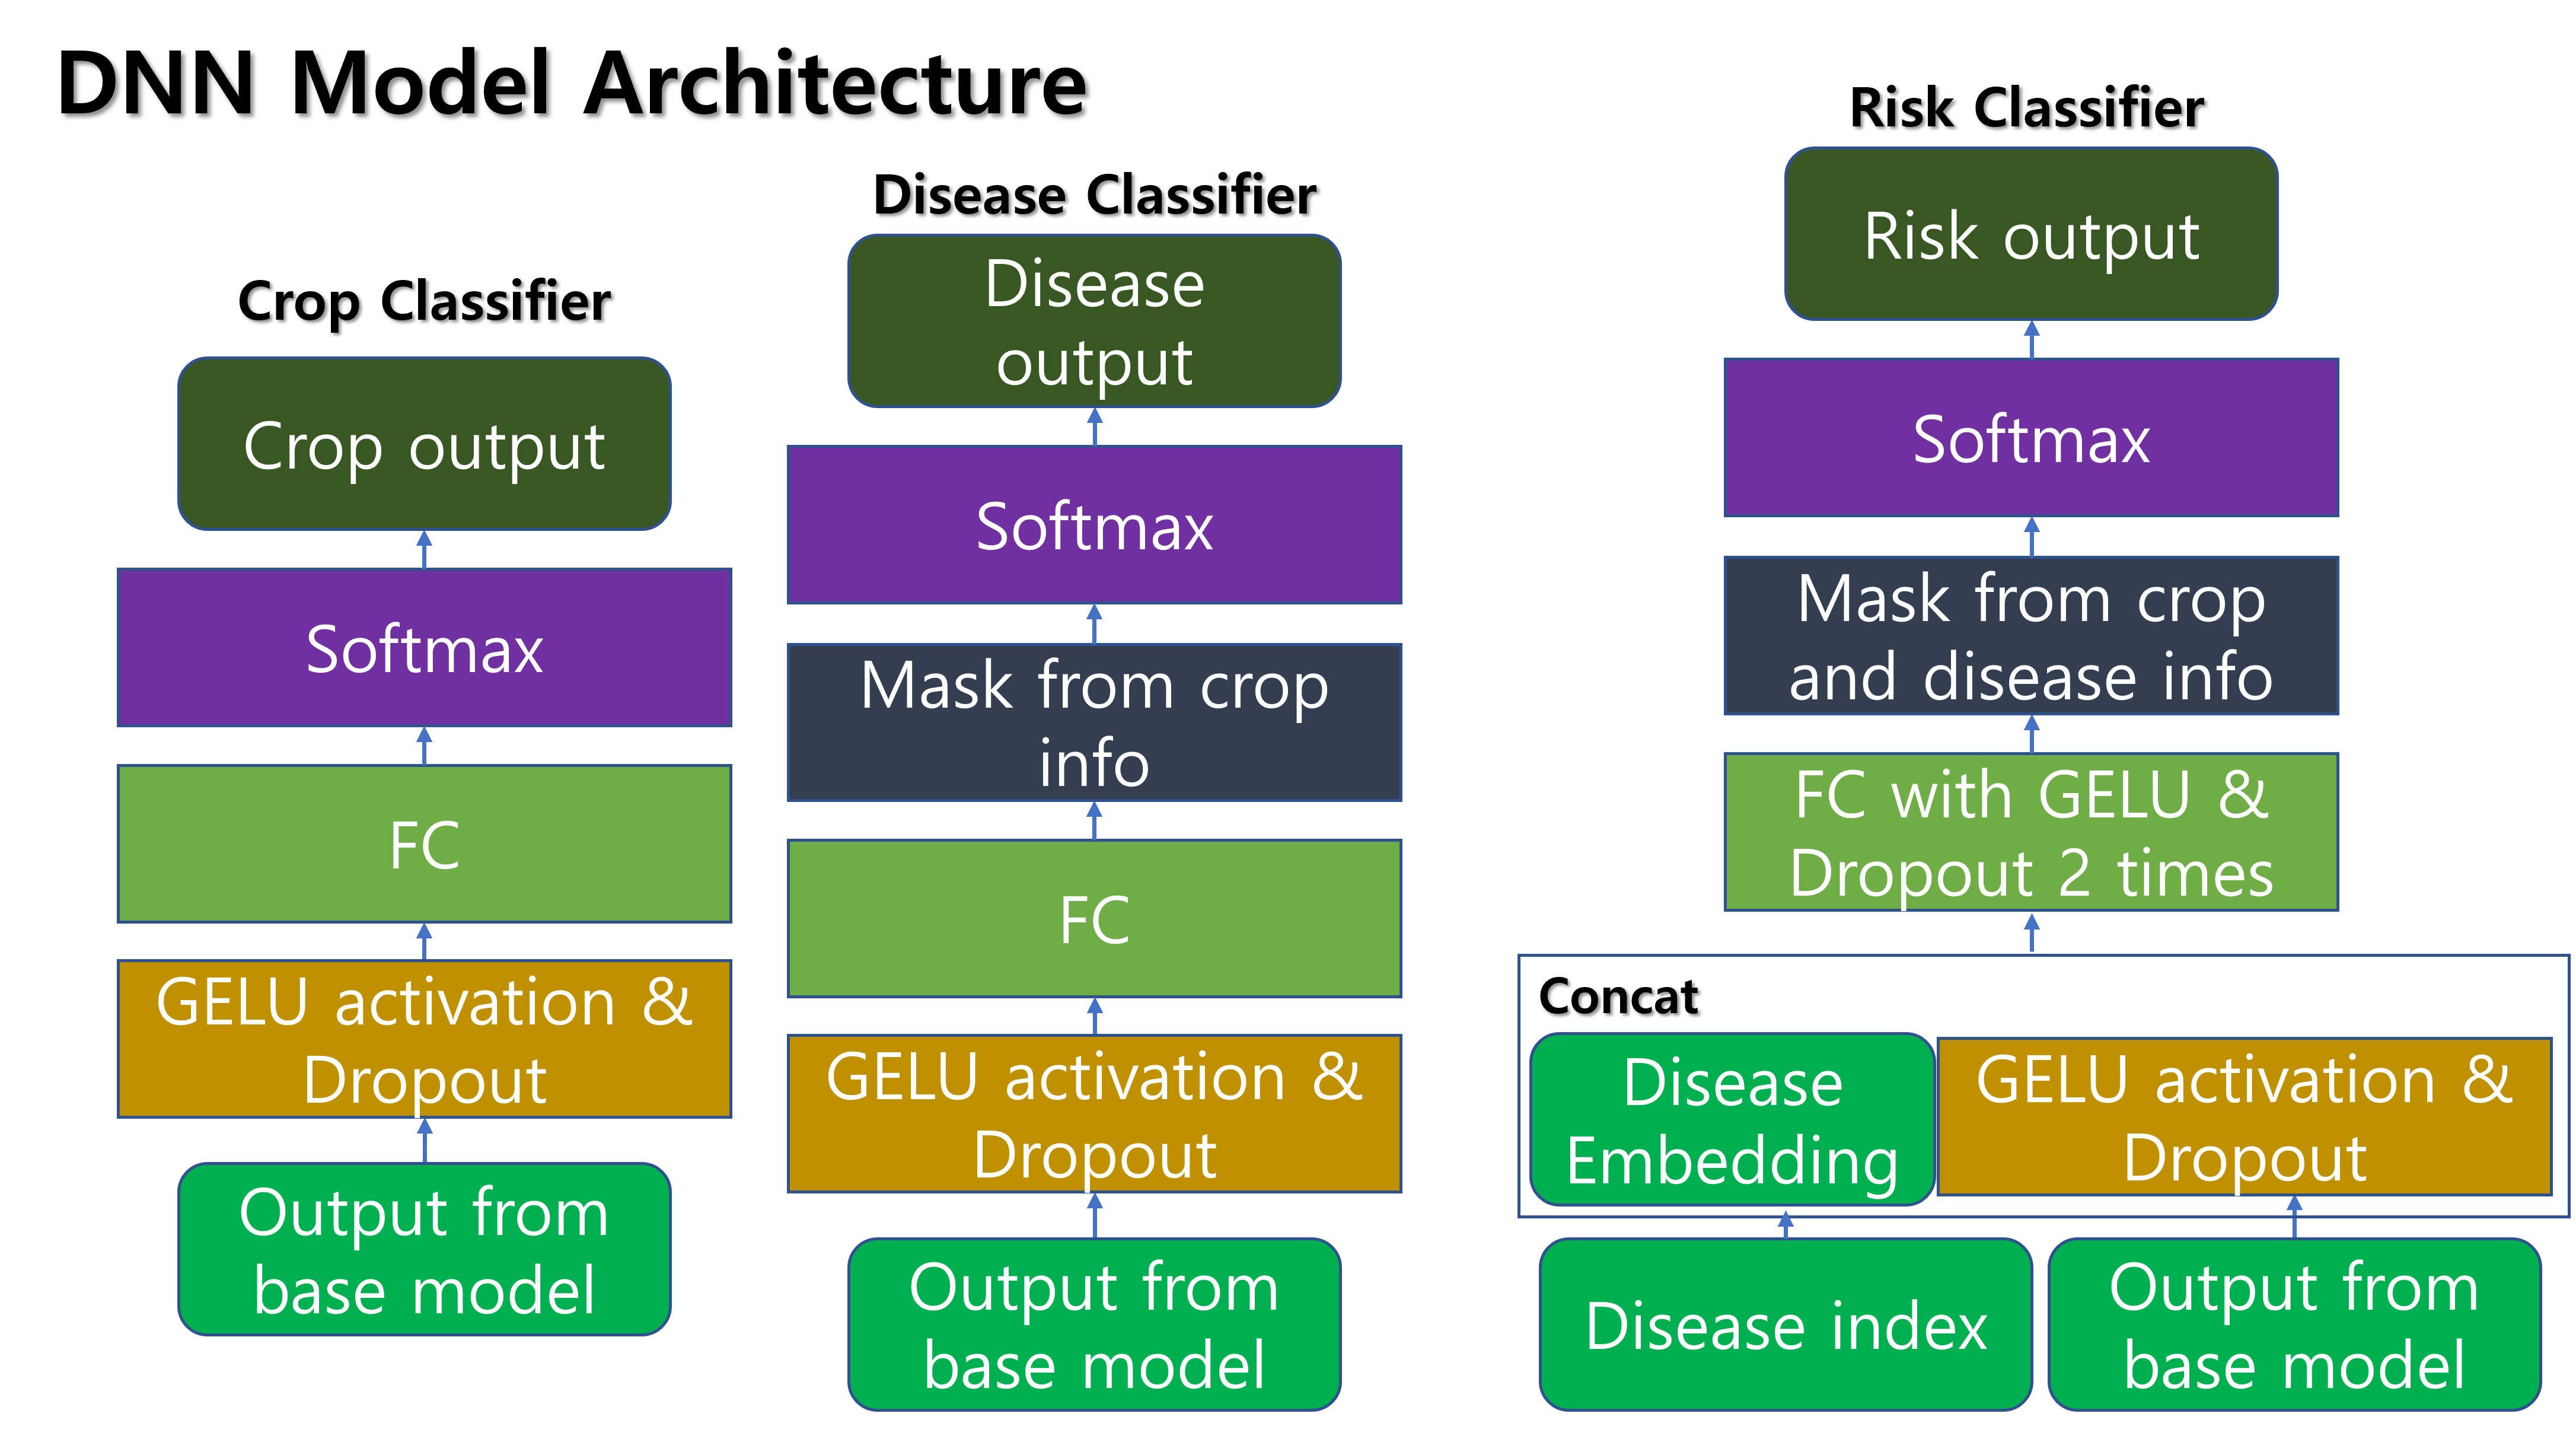

In [8]:
Image("DNN_architectures.png")

### 모델 설명

- input: 식물 이미지
- output: (crop)-(disease)-(risk) 로 이루어진 단일 label #3가지 모두 예측 성공해야함
- (crop)-(disease)-(risk) 순으로 조건부 확률로 생각할 수 있음. crop에 따라 disease 양상이 결정되며, crop과 disease에 따라 결과의 risk 정도가 달라짐.
- (crop)-(disease)-(risk) 순에 따라 예측된 결과를 추가적인 정보원으로 사용하면 예측 정확도가 더욱 높아질 수 있을 것.
-  base model과 이로부터 crop, disease, risk를 예측하는 Deep Neural Network 구조 고안.
- 동시에 Catboost에도 이전에 예측한 조건(예시: disease 예측에는 crop에 대한 정보를 투입하는 것)을 투입하는 구조 고안.

### 실제 모델과 훈련방법

- Big Transfer(https://arxiv.org/pdf/1912.11370.pdf) 를 단일 base model로 하여, base model에 이미지를 넣어 나온 결과를 crop, disease, risk 각각의 classifier에 input으로 넣어 최종 예측 수행.
- Catboost를 이용하여 테이블형 정형 데이터를 활용. crop과 disease를 예측. hyperparameter search를 통해 최적값 모델 선정.
- Deep Neural Network와 Catboost의 crop, disease 예측 결과를 앙상블하여 사용(단순 평균).

### 코드

In [ ]:
# meta_data.py
csv_columns = ['측정시각','내부 온도 1 평균','내부 온도 1 최고','내부 온도 1 최저','내부 온도 2 평균','내부 온도 2 최고',
               '내부 온도 2 최저','내부 온도 3 평균','내부 온도 3 최고','내부 온도 3 최저','내부 온도 4 평균','내부 온도 4 최고',
               '내부 온도 4 최저','내부 습도 1 평균','내부 습도 1 최고','내부 습도 1 최저','내부 습도 2 평균','내부 습도 2 최고',
               '내부 습도 2 최저','내부 습도 3 평균','내부 습도 3 최고','내부 습도 3 최저','내부 습도 4 평균','내부 습도 4 최고',
               '내부 습도 4 최저','내부 이슬점 평균','내부 이슬점 최고','내부 이슬점 최저','내부 CO2 평균','내부 CO2 최고',
               '내부 CO2 최저','외부 풍속 평균','외부 풍속 최고','외부 풍속 최저','내부 EC 1 평균','내부 EC 1 최고','내부 EC 1 최저',
               '내부 PH 1 평균','내부 PH 1 최고','내부 PH 1 최저','배지 중량 평균','배지 중량 최고','배지 중량 최저','양액 온도 평균',
               '양액 온도 최고','양액 온도 최저','외부 풍향 수치','외부 풍향','외부 빗물 시간','외부 누적일사 평균','양액 급액 누적',
               '양액 배액 누적']

use_columns = ['내부 온도 1 평균','내부 온도 1 최고','내부 온도 1 최저',
               '내부 습도 1 평균','내부 습도 1 최고','내부 습도 1 최저',
               '내부 이슬점 평균','내부 이슬점 최고','내부 이슬점 최저',
               '내부 CO2 평균','내부 CO2 최고','내부 CO2 최저',
               '외부 누적일사 평균']

disease_dict = {0:['0'],
                1:['00', 'a5'],
                2:['00', 'a9', 'b3', 'b6', 'b7', 'b8'],
                3:['0'],
                4:['00', 'a7', 'b6', 'b7', 'b8'],
                5:['00', 'a11', 'a12', 'b4', 'b5'],}
real_targets = ['1_00_0', '2_00_0', '2_a5_2', '3_00_0', '3_a9_1', '3_a9_2', '3_a9_3', '3_b3_1', '3_b6_1', '3_b7_1', '3_b8_1', '4_00_0', '5_00_0', '5_a7_2', '5_b6_1', '5_b7_1', '5_b8_1', '6_00_0', '6_a11_1', '6_a11_2', '6_a12_1', '6_a12_2', '6_b4_1', '6_b4_3', '6_b5_1']

disease_encoding = []
for disease_codes in disease_dict.values():
    disease_encoding.extend(disease_codes)
disease_encoding = sorted(list(set(disease_encoding)))
disease_decoding = {}
for k, v in enumerate(disease_encoding):
    disease_decoding[k] = v

disease_mask = {} # 마스크 처리
for k, values in disease_dict.items():
    disease_mask[k] = [True] * len(disease_encoding)
    for v in values:
        disease_mask[k][disease_encoding.index(v)] = False

percentile_num = 50

risk_with_crop_mask = {} # 마스크 처리
for target_name in real_targets:
    crop_i, disease_i, risk_i = target_name.split('_')
    crop_i = int(crop_i) - 1
    if crop_i == 0 or crop_i == 3:
        disease_i = disease_encoding.index('0')
    else:
        disease_i = disease_encoding.index(disease_i)
    risk_i = int(risk_i)
    risk_with_crop_mask[disease_i*10 + crop_i] = [True, True, True, True]
for target_name in real_targets:
    crop_i, disease_i, risk_i = target_name.split('_')
    crop_i = int(crop_i) - 1
    if crop_i == 0 or crop_i == 3:
        disease_i = disease_encoding.index('0')
    else:
        disease_i = disease_encoding.index(disease_i)
    risk_i = int(risk_i)
    risk_with_crop_mask[disease_i*10 + crop_i][risk_i] = False

In [9]:
# data_preprocessing.py

import json
import os
import time
import argparse
from multiprocessing import Pool
import numpy as np
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split, StratifiedKFold

from meta_data import use_columns, disease_encoding

def prepare_dataframe(csv_files, json_files, img_files, save_path, percentile_num=50):
    csv_files.sort()
    if json_files[0] is not None:
        json_files.sort()
    img_files.sort()
    files_list_and_percentile_num = [(csv_file, json_file, img_file, percentile_num) for csv_file, json_file, img_file in zip(csv_files, json_files, img_files)]
    
    start_time = time.time()
    print('Data Loading.')
    with Pool() as pool:
        dict_list = pool.map(return_dict_from_files, files_list_and_percentile_num)
    
    df = pd.DataFrame(dict_list)
    df.to_csv(save_path, index=False)
    print(f"Data Loading Complete. Time Spend: {time.time() - start_time:.4} seconds")
    
            
def make_nan(x):
    if str(x) == '-':
        return np.nan
    return x

def return_dict_from_files(files_list_and_percentile_num: tuple):
    csv_file, json_file, img_file, percentile_num = files_list_and_percentile_num
    df_dict = {}
    
    temp = pd.read_csv(csv_file)
    temp = temp[use_columns]
    temp = temp.applymap(make_nan).astype(np.float64).describe(percentiles=[i/percentile_num for i in range(percentile_num+1)])
    temp_percentiles = temp.iloc[4:-1]
    
    for column in use_columns:
        if "누적일사" in column:
            if temp.loc['count', column] == 0:
                df_dict[column+'_is_exist'] = 0
            else:
                df_dict[column+'_is_exist'] = 1
            if np.isnan(temp_percentiles.loc['0%', column]):
                for i in range(len(temp_percentiles)):
                    df_dict[column+f'_{i}'] = -1
            else:
                for i in range(len(temp_percentiles)):
                    df_dict[column+f'_{i}'] = temp_percentiles.loc[:, column][i]
                    
        elif "CO2" in column:
            if temp.loc['count', column] == 0:
                df_dict[column+'_is_exist'] = 0
            else:
                df_dict[column+'_is_exist'] = 1
            if "최고" in column:
                if np.isnan(temp.loc['max', column]):
                    df_dict[column+'_max'] = -1
                else:
                    df_dict[column+'_max'] = temp.loc['max', column]
            elif "최저" in column:
                if np.isnan(temp.loc['min', column]):
                    df_dict[column+'_min'] = -1
                else:
                    df_dict[column+'_min'] = temp.loc['min', column]
            else:
                if np.isnan(temp_percentiles.loc['0%', column]):
                    for i in range(len(temp_percentiles)):
                        df_dict[column+f'_{i}'] = -1
                else:
                    for i in range(len(temp_percentiles)):
                        df_dict[column+f'_{i}'] = temp_percentiles.loc[:, column][i]
        
        else:
            if "최고" in column:
                df_dict[column+'_max'] = temp.loc['max', column]
            elif "최저" in column:
                df_dict[column+'_min'] = temp.loc['min', column]
            else:
                for i in range(len(temp_percentiles)):
                    df_dict[column+f'_{i}'] = temp_percentiles.loc[:, column][i]
    
    
    df_dict['img_path'] = img_file
    if json_file:
        with open(json_file, 'r', encoding='utf-8') as json_f:
            temp_dict = json.load(json_f)
        
            df_dict['crop'] = temp_dict['annotations']['crop'] - 1
            
            if df_dict['crop'] == 0 or df_dict['crop'] == 3:
                df_dict['disease'] = disease_encoding.index('0')
            else:
                df_dict['disease'] = disease_encoding.index(temp_dict['annotations']['disease'])
            df_dict['risk'] = temp_dict['annotations']['risk']
            xyhw = temp_dict['annotations']['bbox'][0]
            coordinate = [int(xyhw['x']), int(xyhw['y']), int(xyhw['w']), int(xyhw['h'])]
            df_dict['coordinate'] = coordinate
            df_dict['strat'] = str(temp_dict['annotations']['crop']) + str(temp_dict['annotations']['disease']) + str(temp_dict['annotations']['risk']) + str(temp_dict['annotations']['area']) + str(temp_dict['annotations']['grow'])
            
    return df_dict

def kfold_split_save(csv_file, save_folder, n_splits=5, startified='strat'):
    raw_data = pd.read_csv(csv_file)
    target_data = raw_data.drop(columns=['strat'])
    strat = raw_data[[startified]]
    kfolds = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for i, (train_index, test_index) in enumerate(kfolds.split(target_data, strat)):
        X_train, X_test = target_data.iloc[train_index, :], target_data.iloc[test_index, :]
        X_train.to_csv(os.path.join(save_folder, f'{i}_train.csv'), index=False)
        X_test.to_csv(os.path.join(save_folder, f'{i}_test.csv'), index=False)
        
def strat_split_save(csv_file, save_folder, test_size=0.1, stratified='strat'):
    raw_data = pd.read_csv(csv_file)
    strat = raw_data[[stratified]] #strat
    target_data = raw_data.drop(columns=stratified)
    train_set, test_set, _, _ = train_test_split(target_data, strat, test_size=test_size, stratify=strat)
    
    train_set.to_csv(os.path.join(save_folder, 'train.csv'), index=False)
    test_set.to_csv(os.path.join(save_folder, 'test.csv'), index=False)
    
    
if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Select Preprocess Mode')
    parser.add_argument('--task', type=str, required=True, choices=['train', 'test'], help='Select the task')
    parser.add_argument('--data-folder', type=str, default='/data', help='Data folder path')
    parser.add_argument('--processed-csv', type=str, default='processed_train.csv', help='CSV file name to be saved')
    # parser.add_argument('--kfold-save-folder', type=str, default='kfold_dataset', help='kfold dataset folder in csv form')
    parser.add_argument('--stratified-save-folder', type=str, default='stratified_dataset', help='stratified dataset folrder in csv form')
    parser.add_argument('--test-size', type=float, default=0.1, help='Test size to be splitted')
    parser.add_argument('--persentile-num', type=int, default=50, help='How many percentile score to use in preprocessing')
    args = parser.parse_args()
    
    if args.task == 'train':
        print('Preprocessing for train.')
        csv_files = glob(os.path.join(args.data_folder, 'train', '*', '*.csv'))
        json_files = glob(os.path.join(args.data_folder, 'train', '*', '*.json'))
        img_files = glob(os.path.join(args.data_folder, 'train', '*', '*.jpg'))
        # os.makedirs(args.kfold_save_folder, exist_ok=True)
        os.makedirs(args.stratified_save_folder, exist_ok=True)
        
        prepare_dataframe(csv_files, json_files, img_files, args.processed_csv, percentile_num=args.persentile_num)
        # kfold_split_save(args.processed_csv, args.kfold_save_folder, n_splits=10, startified='strat')
        strat_split_save(args.processed_csv, args.stratified_save_folder, test_size=args.test_size, stratified='strat')
        
    elif args.task == 'test':
        print('Preprocessing for test.')
        csv_files = glob(os.path.join(args.data_folder, 'test', '*', '*.csv'))
        json_files = [None] * len(csv_files)
        img_files = glob(os.path.join(args.data_folder, 'test', '*', '*.jpg'))
        
        prepare_dataframe(csv_files, json_files, img_files, args.processed_csv, percentile_num=args.persentile_num)

In [ ]:
# loss.py

import torch
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean', ignore_index=-100):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=ignore_index, reduction='none')

    @torch.cuda.amp.autocast()
    def forward(self, inputs, targets, mixup=None):
        loss = self.loss_fn(inputs, targets)
        pt = torch.exp(-loss)
        F_loss = self.alpha * (1-pt)**self.gamma * loss  # 핵심
        
        if mixup is not None:
            F_loss = F_loss * mixup
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        elif self.reduction == 'none':
            return F_loss

In [ ]:
# model.py

import timm
import torch.nn as nn
import torch
from meta_data import disease_encoding

# resnetv2_50x3_bitm_in21k' 모델 베이스라인으로 사용
class BaseModel(nn.Module):
    def __init__(self, num_classes=1000, drop_p=0., pretrained=True):
        super().__init__()
        self.num_classes = num_classes
        self.model = timm.create_model('resnetv2_50x3_bitm_in21k', pretrained=pretrained, num_classes=num_classes, drop_rate=drop_p,)
            
    @torch.cuda.amp.autocast()
    def forward(self, img):
        return self.model(img)

# classifier 정의

class CropHeadClassifier(nn.Module):
    def __init__(self, num_base_features=1000, num_classes=6, drop_p=0.1):
        super().__init__()
        self.classifier = nn.Linear(num_base_features, num_classes)
        self.act = nn.GELU() # Gaussian Error Linear Units activation 함수
        self.drop = nn.Dropout(drop_p) 
    
    @torch.cuda.amp.autocast() 
    def forward(self, x):
        return self.classifier(self.act(self.drop(x)))

class CropClassifier(nn.Module):
    def __init__(self, num_base_features=1000,num_classes=6, drop_p=0.1):
        super().__init__()
        self.base_model = BaseModel(num_classes=num_base_features, drop_p=drop_p)
        self.classifier = CropHeadClassifier(num_base_features=num_base_features, num_classes=num_classes, drop_p=drop_p)
        
    def forward(self, x, not_use=None):
        return self.classifier(self.base_model(x))
    
class DiseaseHeadClassifier(nn.Module):
    def __init__(self, num_base_features=1000, num_classes=13, drop_p=0.1):
        super().__init__()
        self.classifier = nn.Linear(num_base_features, num_classes)
        self.act = nn.GELU()
        self.drop = nn.Dropout(drop_p)
        
    @torch.cuda.amp.autocast()
    def forward(self, x, mask):
        x = self.classifier(self.act(self.drop(x)))
        x.masked_fill_(mask, -10000.)
        return x

class DiseaseClassifier(nn.Module):
    def __init__(self, num_base_features=1000, num_classes=13, drop_p=0.1):
        super().__init__()
        self.base_model = BaseModel(num_classes=num_base_features, drop_p=drop_p)
        self.classifier = DiseaseHeadClassifier(num_base_features=num_base_features, num_classes=num_classes, drop_p=drop_p)
        
    def forward(self, x, mask):
        return self.classifier(self.base_model(x), mask)
     
class RiskHeadClassifier(nn.Module):
    def __init__(self, num_base_features=1000, hidden_feature=200, num_classes=4, drop_p=0.1, embedding_dim=10):
        super().__init__()
        self.linear = nn.Linear(num_base_features + embedding_dim, hidden_feature)
        self.classifier = nn.Linear(hidden_feature, num_classes)
        self.act = nn.GELU()
        self.drop = nn.Dropout(drop_p)
        self.embedding = nn.Embedding(num_embeddings=len(disease_encoding), embedding_dim=embedding_dim)
    
    @torch.cuda.amp.autocast()
    def forward(self, x, disease_code, mask):
        x = self.act(self.drop(x))
        y = self.drop(self.embedding(disease_code))
        concat = torch.cat([x, y], dim=1)
        out = self.act(self.drop(self.linear(concat)))
        out = self.classifier(out)
        out.masked_fill_(mask, -10000.)
        return out
      
class RiskClassifier(nn.Module):
    def __init__(self, num_base_features=1000, hidden_feature=200, num_classes=4, drop_p=0.1, embedding_dim=100):
        super().__init__()
        self.base_model = BaseModel(num_classes=num_base_features, drop_p=drop_p)
        self.classifier = RiskHeadClassifier(num_base_features=num_base_features, hidden_feature=hidden_feature, num_classes=num_classes, drop_p=drop_p, embedding_dim=embedding_dim)
        
    def forward(self, x, disease_code, mask):
        return self.classifier(self.base_model(x), disease_code, mask)

In [ ]:
# train_cat.py

import os
import argparse
import glob
import pandas as pd
from tqdm import tqdm
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from meta_data import disease_encoding

parser = argparse.ArgumentParser(description='Select Train Mode')
parser.add_argument('--target', type=str, required=True, choices=['crop', 'disease', 'risk'], help='Select target label.')
parser.add_argument('--save-folder', type=str, default=None, help='Save folder for Model. Recommand Not To Use.')
parser.add_argument('--dataset-folder', type=str, default='stratified_dataset', help='Dataset folder made by data preprocessing')
parser.add_argument('--early-stop', type=int, default=1000)
args = parser.parse_args()

BASE_SAVE_FOLDER = 'model_checkpoint/boosting'
EARLY_STOP_COUNT = args.early_stop

target_label = args.target
save_folder = args.save_folder
dataset_folder = args.dataset_folder
if save_folder:
    os.makedirs(save_folder, exist_ok=True)
else:
    if target_label in ('crop', 'disease', 'risk'):
        save_folder = os.path.join(BASE_SAVE_FOLDER, target_label)
        os.makedirs(save_folder, exist_ok=True)
    else:
        print("Check the label name")
        exit()

if target_label == 'crop':
    total_labels = [i for i in range(6)]
    ignored_features = ['img_path', 'coordinate']
    cat_features = ['외부 누적일사 평균_is_exist', '내부 CO2 평균_is_exist','내부 CO2 최고_is_exist','내부 CO2 최저_is_exist']
    drop_labels = ['crop', 'disease', 'risk']
elif target_label == 'disease':
    total_labels = [i for i in range(len(disease_encoding))]
    ignored_features = ['img_path', 'coordinate']
    cat_features = ['외부 누적일사 평균_is_exist', '내부 CO2 평균_is_exist','내부 CO2 최고_is_exist','내부 CO2 최저_is_exist', 'crop']
    drop_labels = ['disease', 'risk']
elif target_label == 'risk':
    total_labels = [i for i in range(4)]
    ignored_features = ['img_path', 'coordinate']
    cat_features = ['외부 누적일사 평균_is_exist', '내부 CO2 평균_is_exist','내부 CO2 최고_is_exist','내부 CO2 최저_is_exist', 'crop', 'disease']
    drop_labels = ['risk']
    
train_csv_files = sorted(glob.glob(dataset_folder + '/*train.csv'))
test_csv_files = sorted(glob.glob(dataset_folder + '/*test.csv'))

for k_fold, (train_csv, test_csv) in enumerate(zip(train_csv_files, test_csv_files)):
    train_df = pd.read_csv(train_csv)
    train_df = train_df.drop(columns=ignored_features)
    train_x, train_y = train_df.drop(columns=drop_labels), train_df[target_label]
    
    test_df = pd.read_csv(test_csv)
    test_df = test_df.drop(columns=ignored_features)
    test_x, test_y = test_df.drop(columns=drop_labels), test_df[target_label]
    
    if target_label == 'crop':
        border_count = [7]
        random_strength = [1]
        leaf_estimation_iterations = [None]
        learning_rate = [0.1]

    elif target_label == 'disease':
        border_count = [64]
        random_strength = [2]
        leaf_estimation_iterations = [None]
        learning_rate = [0.1]

    elif target_label == 'risk':
        border_count = [64]
        random_strength = [2]
        leaf_estimation_iterations = [None]
        learning_rate = [0.1]
        
    grids = [(leaf, learn, streng, border) for leaf in leaf_estimation_iterations for learn in learning_rate for streng in random_strength for border in border_count]
    
    max_acc = -float('inf')
    max_f1 = -float('inf')
    
    for leaf, learn, streng, border in tqdm(grids):
        model = CatBoostClassifier(
            iterations = 1000000,
            task_type = 'GPU',
            devices='0',
            thread_count = 16,
            learning_rate = learn,
            border_count=border,
            random_strength=streng,
            leaf_estimation_iterations=leaf,
            auto_class_weights='Balanced',
            max_depth=8,
            eval_metric='TotalF1',
            use_best_model=True,
            cat_features=cat_features,
            verbose=True,
        )
        model.fit(
            train_x, train_y,
            eval_set = [(test_x, test_y)],
            early_stopping_rounds=EARLY_STOP_COUNT
        )
        
        preds = model.predict(test_x)
        res = model.score(test_x, test_y)
        report = classification_report(test_y, preds)
        f1_score_result = f1_score(test_y, preds, average='macro', labels=total_labels)
        print(report)
        preds_train = model.predict(train_x)
        report = classification_report(train_y, preds_train)
        print( '-' *100)
        print(report)
        print(f'{target_label}--F1 Score:', f1_score_result, '\tAcc:', res, '\tBest F1 Score:', max(max_f1, f1_score_result), '\tBest Acc:', max(max_acc, res))

In [ ]:
# train_torch.py

import argparse
import os
import glob
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, accuracy_score
from model import BaseModel, CropHeadClassifier, DiseaseHeadClassifier, RiskHeadClassifier
from utils import TrainValDataset, total_acc_cal
from meta_data import disease_encoding
from loss import FocalLoss

# parser 
parser = argparse.ArgumentParser(description='Select Train Mode')
parser.add_argument('--save-folder', type=str, default=None, help='Save folder for Model. Recommand Not To Use.')
parser.add_argument('--dataset-folder', type=str, default='stratified_dataset', help='dataset folder made by data preprocessing')
parser.add_argument('--checkpoint_cat', type=str, default='model_checkpoint/boosting', help='Checkpoint file for pytorch model', required=False)
parser.add_argument('--base-drop', type=float, default=0.3)
parser.add_argument('--crop-drop', type=float, default=0.3)
parser.add_argument('--disease-drop', type=float, default=0.3)
parser.add_argument('--risk-drop', type=float, default=0.3)
parser.add_argument('--learning-rate', type=float, default=0.00001)
parser.add_argument('--weight-decay', type=float, default=0.01)
parser.add_argument('--batch-size', type=int, default=44)
parser.add_argument('--num-workers', type=int, default=4)
parser.add_argument('--early-stop', type=int, default=250)

args = parser.parse_args()

BASE_SAVE_FOLDER = 'model_checkpoint/torch'
BASE_DROP_RATE = args.base_drop
CROP_DROP_RATE = args.crop_drop
DISEASE_DROP_RATE = args.disease_drop
RISK_DROP_RATE = args.risk_drop
LEARNING_RATE = args.learning_rate
WEIGHT_DECAY = args.weight_decay
BATCH_SIZE = args.batch_size
NUM_WORKERS = args.num_workers
EARLY_STOP_COUNT = args.early_stop
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


save_folder = args.save_folder
dataset_folder = args.dataset_folder
if save_folder:
    os.makedirs(save_folder, exist_ok=True)
else:
    save_folder = os.path.join(BASE_SAVE_FOLDER, 'trained')
    os.makedirs(save_folder, exist_ok=True)

total_crop_labels = [i for i in range(6)]
total_disease_labels = [i for i in range(len(disease_encoding))]
total_risk_labels = [i for i in range(4)]

train_csv_files = sorted(glob.glob(dataset_folder + '/*train.csv'))
test_csv_files = sorted(glob.glob(dataset_folder + '/*test.csv'))

crop_cat = CatBoostClassifier()
disease_cat = CatBoostClassifier()
for cat_file_path, cat_model in zip(sorted(glob.glob(args.checkpoint_cat+'/*/*_0.pkl')), [crop_cat, disease_cat]):
    cat_model.load_model(cat_file_path)

    
# ford / batch 학습 
for k_fold, (train_csv, test_csv) in enumerate(zip(train_csv_files, test_csv_files)):
    print("Train csv and Test csv:", train_csv, '\t', test_csv)
    train_dataset = TrainValDataset(train_csv, train=True, target_label='total')
    test_dataset = TrainValDataset(test_csv, train=False, target_label='total')
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, prefetch_factor=BATCH_SIZE*2, drop_last=True, pin_memory=True)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, prefetch_factor=BATCH_SIZE*2, drop_last=False, pin_memory=True)
    
    base_model = BaseModel(drop_p=BASE_DROP_RATE)
    base_model = torch.nn.DataParallel(base_model).to(DEVICE)
    crop_model = CropHeadClassifier(drop_p=CROP_DROP_RATE)
    crop_model = torch.nn.DataParallel(crop_model).to(DEVICE)
    disease_model = DiseaseHeadClassifier(drop_p=DISEASE_DROP_RATE)
    disease_model = torch.nn.DataParallel(disease_model).to(DEVICE)
    risk_model = RiskHeadClassifier(drop_p=RISK_DROP_RATE)
    risk_model = torch.nn.DataParallel(risk_model).to(DEVICE)
    
    scaler = torch.cuda.amp.GradScaler()
    
    loss_fn = FocalLoss()
    loss_fn_disease_risk = FocalLoss(ignore_index=0) # loss에 idx적용
    optimizer = torch.optim.AdamW([
        {'params': base_model.parameters()}, 
        {'params': crop_model.parameters()}, 
        {'params': disease_model.parameters()}, 
        {'params': risk_model.parameters()}], lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    writer = SummaryWriter(os.path.join(save_folder, 'log')) 
    step = 0
    stop_count = 0
    current_epoch = 0
    max_f1_average = -float('inf')
    max_f1_total = -float('inf')
    max_f1_ensemble = -float('inf')
    max_f1_total_risk_care = -float('inf')
    max_f1_ensemble_risk_care = -float('inf')
    max_average_acc = -float('inf')
    max_all_acc = -float('inf')
    answer_crop = test_dataset.df['crop'].to_list()
    answer_disease = test_dataset.df['disease'].to_list()
    answer_risk = test_dataset.df['risk'].to_list()
    answer_total = [disease_idx*100 + crop_idx*10 + risk_idx for crop_idx, disease_idx, risk_idx in zip(answer_crop, answer_disease, answer_risk)]

    # 학습진행
    while True:
        stop_count += 1
        current_epoch += 1
        base_model.train()
        crop_model.train()
        disease_model.train()
        risk_model.train()
        
        for data in train_dataloader:
            img, crop, disease, risk, disease_mask, risk_mask = data
            
            with torch.cuda.amp.autocast():
                img = img.to(DEVICE)
                crop = crop.to(DEVICE)
                disease = disease.to(DEVICE)
                risk = risk.to(DEVICE)
                disease_mask = disease_mask.to(DEVICE)
                risk_mask = risk_mask.to(DEVICE)
                img_processed = base_model(img)
                crop_logits = crop_model(img_processed)
                disease_logits = disease_model(img_processed, disease_mask)
                risk_logits = risk_model(img_processed, disease, risk_mask)
                loss = loss_fn(crop_logits, crop) + loss_fn_disease_risk(disease_logits, disease) + loss_fn_disease_risk(risk_logits, risk) #1.5, 15
                
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            
            writer.add_scalar(f'Loss/train_step_{k_fold}', loss, step)
            step += 1
        
        base_model.eval()
        crop_model.eval()
        disease_model.eval()
        risk_model.eval()
        total_loss = 0
        preds_crop = []
        preds_disease = []
        preds_risk = []
        preds_crop_ensem = []
        preds_disease_ensem = []
        preds_risk_ensem = []
        with torch.no_grad():
            for idx, data in enumerate(test_dataloader):
                img, crop, disease, risk, disease_mask, risk_mask = data
                img = img.to(DEVICE)
                crop = crop.to(DEVICE)
                disease = disease.to(DEVICE)
                risk = risk.to(DEVICE)
                disease_mask_np = disease_mask.numpy()
                disease_mask = disease_mask.to(DEVICE)
                risk_mask = risk_mask.to(DEVICE)
                with torch.cuda.amp.autocast(): 
                    img_processed = base_model(img)
                    crop_logits = crop_model(img_processed)
                    disease_logits = disease_model(img_processed, disease_mask)
                    risk_logits = risk_model(img_processed, disease, risk_mask)
                    
                    loss = loss_fn(crop_logits, crop) + loss_fn_disease_risk(disease_logits, disease) + loss_fn_disease_risk(risk_logits, risk)
                
                    target_df = test_dataset.df.iloc[BATCH_SIZE*idx: BATCH_SIZE*(idx + 1), :].drop(columns=['img_path', 'coordinate', 'crop', 'disease', 'risk'])
                    crop_boost_pro = crop_cat.predict_proba(target_df)
                    crop_DL_pro = crop_logits.softmax(dim=-1).detach().cpu().numpy()
                    crop_idx_list = np.argmax(crop_DL_pro + crop_boost_pro, axis=-1).tolist()
                    preds_crop_ensem.extend(crop_idx_list)
                    
                    
                    disease_DL_pro = disease_logits.softmax(dim=-1).detach().cpu().numpy()
                    target_df = test_dataset.df.iloc[BATCH_SIZE*idx: BATCH_SIZE*(idx + 1), :].drop(columns=['img_path', 'coordinate', 'disease', 'risk'])
                    disease_boost_pro = disease_cat.predict_proba(target_df)
                    disease_boost_pro = np.ma.MaskedArray(data=disease_boost_pro, mask=disease_mask_np)
                    disease_idx_list = np.argmax(disease_DL_pro + disease_boost_pro.data, axis=-1).tolist()
                    preds_disease_ensem.extend(disease_idx_list)
                
                
                total_loss += loss * len(img)
                preds_crop.extend(np.argmax(crop_DL_pro, axis=-1))
                preds_disease.extend(np.argmax(disease_DL_pro, axis=-1))
                preds_risk.extend(torch.argmax(risk_logits, dim=-1).detach().cpu().tolist())
                
                
            preds_total = [disease_idx*100 + crop_idx*10 + risk_idx for crop_idx, disease_idx, risk_idx in zip(preds_crop, preds_disease, preds_risk)]
            preds_total_ensem = [disease_idx*100 + crop_idx*10 + risk_idx for crop_idx, disease_idx, risk_idx in zip(preds_crop_ensem, preds_disease_ensem, preds_risk)]
            f1_score_crop = f1_score(answer_crop, preds_crop, average='macro', labels=total_crop_labels)
            f1_score_crop_ensem = f1_score(answer_crop, preds_crop_ensem, average='macro', labels=total_crop_labels)
            f1_score_disease = f1_score(answer_disease, preds_disease, average='macro', labels=total_disease_labels)
            f1_score_disease_ensem = f1_score(answer_disease, preds_disease_ensem, average='macro', labels=total_disease_labels)
            f1_score_risk = f1_score(answer_risk, preds_risk, average='macro', labels=total_risk_labels)
            f1_score_total = f1_score(answer_total, preds_total, average='macro')
            f1_score_total_ensem = f1_score(answer_total, preds_total_ensem, average='macro')
            
            acc_score_crop = accuracy_score(answer_crop, preds_crop)
            acc_score_disease = accuracy_score(answer_disease, preds_disease)
            acc_score_risk = accuracy_score(answer_risk, preds_risk)
            #acc_score_total = accuracy_score(answer_total, preds_total)
            
            writer.add_scalar(f'Loss/test_epoch_{k_fold}', total_loss/len(test_dataset), current_epoch)
            writer.add_scalar(f'Acc/Crop_{k_fold}', acc_score_crop, current_epoch)
            writer.add_scalar(f'Acc/Disease_{k_fold}', acc_score_disease, current_epoch)
            writer.add_scalar(f'Acc/Risk_{k_fold}', acc_score_risk, current_epoch)
            #writer.add_scalar(f'Acc_total/test_epoch_{k_fold}', acc_score_total, current_epoch)
            writer.add_scalar(f'F1/Crop_{k_fold}', f1_score_crop, current_epoch)
            writer.add_scalar(f'F1/Disease_{k_fold}', f1_score_disease, current_epoch)
            writer.add_scalar(f'F1/Risk_{k_fold}', f1_score_risk, current_epoch)
            writer.add_scalar(f'F1/Total_{k_fold}', f1_score_total, current_epoch)
            writer.add_scalar(f'F1/En_Crop_{k_fold}', f1_score_crop_ensem, current_epoch)
            writer.add_scalar(f'F1/En_Disease_{k_fold}', f1_score_disease_ensem, current_epoch)
            writer.add_scalar(f'F1/En_Risk_{k_fold}', f1_score_risk, current_epoch)
            writer.add_scalar(f'F1/En_Total_{k_fold}', f1_score_total_ensem, current_epoch)
            
            f1_average_score = (f1_score_crop + f1_score_disease + f1_score_risk) / 3
            acc_average_score = (acc_score_crop + acc_score_disease + acc_score_risk) / 3
            acc_all_score = total_acc_cal(preds_crop, answer_crop, preds_disease, answer_disease, preds_risk, answer_risk)        
            writer.add_scalar(f'F1/Average_{k_fold}', f1_average_score, current_epoch)
            writer.add_scalar(f'Acc/Average_{k_fold}', acc_average_score, current_epoch)
            writer.add_scalar(f'Acc/All_{k_fold}', acc_all_score, current_epoch)
    
         # 앙상블
        if max_f1_total < f1_score_total:
            stop_count = 0
            max_f1_total = f1_score_total
            torch.save({'base_model': base_model.module.state_dict(),
                        'crop_model': crop_model.module.state_dict(),
                        'disease_model': disease_model.module.state_dict(),
                        'risk_model': risk_model.module.state_dict(),}, os.path.join(save_folder, f'max_f1_total_{k_fold}.pt'))
        
        if max_f1_ensemble < f1_score_total_ensem:
            stop_count = 0
            max_f1_ensemble = f1_score_total_ensem
            torch.save({'base_model': base_model.module.state_dict(),
                        'crop_model': crop_model.module.state_dict(),
                        'disease_model': disease_model.module.state_dict(),
                        'risk_model': risk_model.module.state_dict(),}, os.path.join(save_folder, f'max_f1_ensem_{k_fold}.pt'))
        
        if max_f1_total_risk_care < f1_score_total and f1_score_crop == 1 and f1_score_disease == 1:
            stop_count = 0
            max_f1_total_risk_care = f1_score_total
            print(f'DL only F1 Score: {max_f1_total_risk_care}')
            torch.save({'base_model': base_model.module.state_dict(),
                        'crop_model': crop_model.module.state_dict(),
                        'disease_model': disease_model.module.state_dict(),
                        'risk_model': risk_model.module.state_dict(),}, os.path.join(save_folder, f'max_f1_total_risk_care_{k_fold}.pt'))
        
        if max_f1_ensemble_risk_care < f1_score_total_ensem and f1_score_crop_ensem == 1 and f1_score_disease_ensem == 1:
            stop_count = 0
            max_f1_ensemble_risk_care = f1_score_total_ensem
            print(f'Ensemble F1 Score: {max_f1_ensemble_risk_care}')
            torch.save({'base_model': base_model.module.state_dict(),
                        'crop_model': crop_model.module.state_dict(),
                        'disease_model': disease_model.module.state_dict(),
                        'risk_model': risk_model.module.state_dict(),}, os.path.join(save_folder, f'max_f1_ensem_risk_care_{k_fold}.pt'))
        
        
        if stop_count == EARLY_STOP_COUNT:
            print(f'{k_fold}: Training Complete.')
            break

In [ ]:
# predict.py

import argparse
import glob
import re
import csv
from multiprocessing import Pool
from tqdm import tqdm
from catboost import CatBoostClassifier
import torch
from torch.utils.data import DataLoader
from model import BaseModel, CropHeadClassifier, DiseaseHeadClassifier, RiskHeadClassifier
from utils import TrainValDataset, ensemble_cal, ensemble_cal_with_mask
from meta_data import disease_encoding, disease_decoding

parser = argparse.ArgumentParser(description='It is for predict')
parser.add_argument('--checkpoint-torch', type=str, default='model_checkpoint/torch/trained/max_f1_total_0.pt', help='Checkpoint file for pytorch model', required=False)
parser.add_argument('--checkpoint-cat-crop', type=str, default='model_checkpoint/boosting/crop/crop_0.pkl', help='Checkpoint file for pytorch model', required=False)
parser.add_argument('--checkpoint-cat-disease', type=str, default='model_checkpoint/boosting/disease/disease_0.pkl', help='Checkpoint file for pytorch model', required=False)
parser.add_argument('--csv-file', type=str, default='preprocessed_test.csv', required=False)
parser.add_argument('--csv-save', type=str, default='result.csv', required=False)
parser.add_argument('--batch-size', type=int, default=180, required=False)

args = parser.parse_args()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = args.batch_size
NUM_WORKERS = 4
total_crop_labels = [i for i in range(6)]
total_disease_labels = [i for i in range(len(disease_encoding))]
total_risk_labels = [i for i in range(4)]
test_csv = args.csv_file
target_labels = ['crop', 'disease', 'risk']

print("Start Predict")

base_model = BaseModel(pretrained=False).to(DEVICE)
crop_model = CropHeadClassifier().to(DEVICE)
disease_model = DiseaseHeadClassifier().to(DEVICE)
risk_model = RiskHeadClassifier().to(DEVICE)

checkpoint = torch.load(args.checkpoint_torch, map_location=DEVICE)
base_model.load_state_dict(checkpoint['base_model'])
crop_model.load_state_dict(checkpoint['crop_model'])
disease_model.load_state_dict(checkpoint['disease_model'])
risk_model.load_state_dict(checkpoint['risk_model'])
del checkpoint

crop_cat = CatBoostClassifier()
disease_cat = CatBoostClassifier()
crop_cat.load_model(args.checkpoint_cat_crop)
disease_cat.load_model(args.checkpoint_cat_disease)

base_model.eval()
crop_model.eval()
disease_model.eval()
risk_model.eval()

test_dataset = TrainValDataset(test_csv, train=False, target_label='crop')
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, prefetch_factor=BATCH_SIZE*2, drop_last=False, pin_memory=True)

img_tensors = []
preds_crop = []
preds_disease = []
preds_risk = []

for current_label in target_labels:
    if current_label != 'crop':
        if current_label == 'disease':
            test_dataset._change_label_and_update_crop(preds_crop)
        else:
            test_dataset._change_label_and_update_disease(preds_disease)
    
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            if current_label == 'crop': # label에 따라 마스트 적용 + 모델 적용
                list_for_crop_prediction = []
                for img_idx, data in tqdm(enumerate(test_dataloader)):
                    img = data
                    img = img.to(DEVICE)
                    img_processed = base_model(img)
                    img_tensors.append(img_processed.detach().cpu())
                    crop_DL_pro = crop_model(img_processed).softmax(dim=-1).detach().cpu().numpy()
                    target_df = test_dataset.df.iloc[BATCH_SIZE*img_idx: BATCH_SIZE*(img_idx + 1), :].drop(columns=['img_path'])
                    list_for_crop_prediction.append((crop_DL_pro, target_df, crop_cat))
                
                with Pool() as pool:
                    preds_crop = pool.map(ensemble_cal, list_for_crop_prediction)
                preds_crop = [index for index_list in preds_crop for index in index_list]
                    
            elif current_label == 'disease':
                list_for_disease_prediction  = []
                for img_idx, data in tqdm(enumerate(test_dataloader)):
                    disease_mask = data
                    img_processed = img_tensors[img_idx].to(DEVICE)
                    disease_DL_pro = disease_model(img_processed, disease_mask.to(DEVICE)).softmax(dim=-1).detach().cpu().numpy()
                    target_df = test_dataset.df.iloc[BATCH_SIZE*img_idx: BATCH_SIZE*(img_idx + 1), :].drop(columns=['img_path'])
                    list_for_disease_prediction.append((disease_DL_pro, target_df, disease_cat, disease_mask))
                
                with Pool() as pool:
                    preds_disease = pool.map(ensemble_cal_with_mask, list_for_disease_prediction)
                preds_disease = [index for index_list in preds_disease for index in index_list]
                    
            elif current_label == 'risk':
                for img_idx, data in tqdm(enumerate(test_dataloader)):
                    disease, risk_mask = data
                    img_processed = img_tensors[img_idx].to(DEVICE)
                    risk_mask_np = risk_mask.numpy()
                    disease = disease.to(DEVICE)
                    risk_mask = risk_mask.to(DEVICE)
                    
                    risk_idx_list = torch.argmax(risk_model(img_processed, disease, risk_mask), dim=-1).detach().cpu().tolist()
                    preds_risk.extend(risk_idx_list)
                
                
preds_crop = [str(i+1) for i in preds_crop]
preds_disease = [disease_decoding[i] if i != 0 else '00' for i in preds_disease]
preds_risk = [str(i) for i in preds_risk]
img_paths = test_dataset.df['img_path'].to_list()

predicted_answer = [[re.findall(r'[0-9]+', image_path)[-1], i + '_' + j + '_' + k] for image_path, i, j, k in zip(img_paths, preds_crop, preds_disease, preds_risk)]
column_names = ['image', 'label']

with open(args.csv_save, 'w', encoding='utf-8') as f:
    writer = csv.writer(f)
    
    writer.writerow(column_names)
    writer.writerows(predicted_answer)